# Figures of theory-kernel-analysis project

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

(0.6, 1.1)

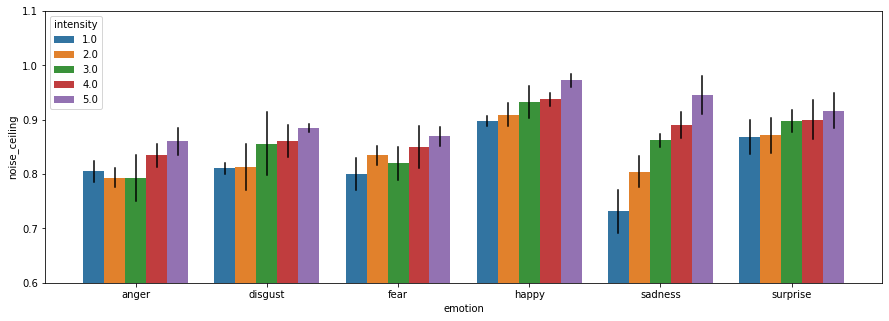

In [115]:
nc = pd.read_csv('../data/noise_ceilings.tsv', sep='\t', index_col=0)
nc = nc.query("participant_id == 'between_subjects' & intensity != 0")
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.barplot(x='emotion', y='noise_ceiling', hue='intensity', data=nc, ax=ax)
idx = 0
for i, container in enumerate(ax.containers):
    for ii, bar in enumerate(container.get_children()):
        mid = bar.xy[0] + bar.get_width() / 2
        sd = nc.sort_values(['intensity']).iloc[idx, -1]
        ax.plot([mid, mid], [bar.get_height()-sd*2, bar.get_height()+sd*2], c='k')
        idx += 1
        
ax.set_ylim(0.6, 1.1)